<a href="https://colab.research.google.com/github/heerakesavan/CE888-Data-Science-and-Decision-making/blob/Master/Lab%208/Transfer_learning_Feature_Extractoion_Heera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.path.isfile('./data.zip'):
  print('Already downloaded!')
else:
  !wget https://github.com/sagihaider/CE888_2021/raw/main/Lab_8/data.zip

--2021-05-05 13:32:13--  https://github.com/sagihaider/CE888_2021/raw/main/Lab_8/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_8/data.zip [following]
--2021-05-05 13:32:13--  https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_8/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20194537 (19M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  19.26M  --.-KB/s    in 0.1s    

2021-05-05 13:32:13 (186 MB/s) - ‘data.zip’ saved [20194537/20194537]



In [2]:
# Unzip training data
from zipfile import ZipFile
file_name = "./data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import itertools
for root, dirs, files in os.walk("./data"):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))
    count = 0
    for (file, i) in itertools.product(files, range(0, 10, 202)):  # printing 10th files
      if file.endswith(f'{i}.jpg'):
        print(len(path) * '---', file)
      count = count + 1
    print('Total number of files in this dir:', count)

--- data
Total number of files in this dir: 0
------ Humans
--------- rider-10.jpg
--------- rider-50.jpg
--------- rider-100.jpg
--------- rider-160.jpg
--------- rider-20.jpg
--------- rider-170.jpg
--------- rider-110.jpg
--------- rider-80.jpg
--------- rider-120.jpg
--------- rider-70.jpg
--------- rider-140.jpg
--------- rider-150.jpg
--------- rider-60.jpg
--------- rider-200.jpg
--------- rider-40.jpg
--------- rider-30.jpg
--------- rider-130.jpg
--------- rider-90.jpg
--------- rider-190.jpg
--------- rider-180.jpg
Total number of files in this dir: 202
------ dogs
--------- dog.110.jpg
--------- dog.10.jpg
--------- dog.30.jpg
--------- dog.160.jpg
--------- dog.200.jpg
--------- dog.170.jpg
--------- dog.150.jpg
--------- dog.130.jpg
--------- dog.100.jpg
--------- dog.50.jpg
--------- dog.20.jpg
--------- dog.180.jpg
--------- dog.190.jpg
--------- dog.70.jpg
--------- dog.60.jpg
--------- dog.40.jpg
--------- dog.120.jpg
--------- dog.90.jpg
--------- dog.140.jpg
--------

In [4]:
# Make a new base directory
base_dir = './data_dhch'
if os.path.exists(base_dir):
  print('Already exists!')
else:
  os.mkdir(base_dir)

In [5]:
train_dir = os.path.join(base_dir, 'train')
if os.path.exists(train_dir):
  print('Already exists!')
else:
  os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if os.path.exists(validation_dir):
  print('Already exists!')
else:
  os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if os.path.exists(test_dir):
  print('Already exists!')
else:
  os.mkdir(test_dir)

In [6]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [7]:
import shutil

train_file_nums = range(1, 101 + 1)
validation_file_nums = range(102, 151 + 1)
test_file_nums = range(152, 202 + 1)
def data_splits(fnames, file_nums, src, dst):
  for fname in [fnames + '{}.jpg'.format(i) for i in file_nums]:
    shutil.copyfile(os.path.join(src, fname), os.path.join(dst, fname))
data_splits('rider-', train_file_nums, './data/Humans', train_dir)
data_splits('rider-', validation_file_nums, './data/Humans', validation_dir)
data_splits('rider-', test_file_nums, './data/Humans', test_dir)

data_splits('cat.', train_file_nums, './data/cats', train_dir)
data_splits('cat.', validation_file_nums, './data/cats', validation_dir)
data_splits('cat.', test_file_nums, './data/cats', test_dir)

data_splits('horse-', train_file_nums, './data/horses', train_dir)
data_splits('horse-', validation_file_nums, './data/horses', validation_dir)
data_splits('horse-', test_file_nums, './data/horses', test_dir)

data_splits('dog.', train_file_nums, './data/dogs', train_dir)
data_splits('dog.', validation_file_nums, './data/dogs', validation_dir)
data_splits('dog.', test_file_nums, './data/dogs', test_dir)

In [8]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [9]:
import re
def label_img(img):
    word_label = re.split('\W+', img)[0]
    if word_label == 'dog': return [0, 0, 0, 1]
    elif word_label == 'horse': return [0, 0, 1, 0]
    elif word_label == 'cat': return [0, 1, 0, 0]
    elif word_label == 'rider': return [1, 0, 0, 0]

In [10]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [11]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(404, 224, 224, 3)
(200, 224, 224, 3)
(204, 224, 224, 3)


In [12]:
## InceptionResNetV2

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [13]:
model = InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

225214464/225209952 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________

In [14]:
last_layer = model.get_layer('avg_pool').output
out = Dense(4, activation='softmax', name='output')(last_layer)
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='xception.h5', save_best_only=True),
]

In [17]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10,
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
41/41 [==============================] - 49s 197ms/step - loss: 0.9309 - acc: 0.6370 - val_loss: 0.1346 - val_acc: 0.9650
Epoch 2/10
41/41 [==============================] - 4s 104ms/step - loss: 0.2107 - acc: 0.9537 - val_loss: 0.0814 - val_acc: 0.9800
Epoch 3/10
41/41 [==============================] - 4s 105ms/step - loss: 0.1058 - acc: 0.9612 - val_loss: 0.0715 - val_acc: 0.9850
Epoch 4/10
41/41 [==============================] - 4s 105ms/step - loss: 0.0756 - acc: 0.9744 - val_loss: 0.0650 - val_acc: 0.9800
Epoch 5/10
41/41 [==============================] - 4s 106ms/step - loss: 0.0549 - acc: 0.9894 - val_loss: 0.0723 - val_acc: 0.9800
Epoch 6/10
41/41 [==============================] - 4s 105ms/step - loss: 0.0280 - acc: 0.9982 - val_loss: 0.0809 - val_acc: 0.9800
Epoch 7/10
41/41 [==============================] - 4s 105ms/step - loss: 0.0268 - acc: 0.9994 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 8/10
41/41 [==============================] - 4s 106ms/step - loss: 0

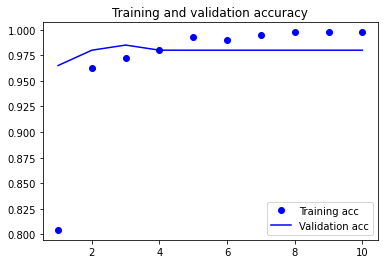

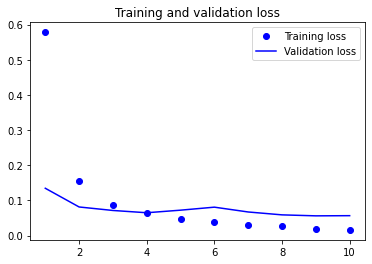

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='macro')
auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9975247383117676
Val Accuracy:	 0.9800000190734863
Test Accuracy:	 0.9656862745098039
Precision:	 0.9717498110355254
Recall:		 0.9656862745098039
F1 Score:	 0.9683333333333333
AUC:		 0.9779411764705883
